In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp, random, jit, grad, vmap
from jax.lax import fori_loop, while_loop, switch, cond
from jax._src.lax.slicing import dynamic_slice

from collections import namedtuple
from functools import partial

In [ ]:
# CONST
ALPHA = .3

# activation functions and activation derivatives
SIGMOID = 0
RELU = 1
ELU = 2
LRELU = 3
TANH = 4

# sigmoid
@jit
def sigmoid(x):
  return 1 / (1 + jnp.exp(-x))

@jit
def d_sigmoid(x):
  f_x = sigmoid(x)
  return f_x * (1 - f_x)

# ReLU
@jit
def relu(x):
  return (x > 0) * x
@jit
def d_relu(x):
  return (x > 0) * 1.0

# ELU
@jit
def elu(x):
  return ((x > 0) * x) + ((x <= 0) * (jnp.exp(x) - 1) * ALPHA)

@jit
def d_elu(x):
  return ((x > 0) * 1.0) + ((x <= 0) * (elu(x) + ALPHA))

# Leaky ReLU which at ALPHA = 1 becomes the identity function
@jit
def lrelu(x):
  return ((x > 0) * x) + ((x <= 0) * x * ALPHA)

@jit
def d_lrelu(x):
  return ((x > 0) * 1.0) + ((x <= 0) * ALPHA)

# hyperbolic tan (clamped to the range [-10, 10] otherwise errors)
@jit
def tanh(x):
  x = ((x > 10) * 10) + (((x >= -10) & (x <= 10)) * x) + ((x < -10) * -10)

  e_pos = jnp.exp(x)
  e_neg = jnp.exp(-x)

  return (e_pos - e_neg) / (e_pos + e_neg)

@jit
def d_tanh(x):
  return 1 - tanh(x)**2

# Generic choice function
@jit
def activation(x, func):
  return switch(func, [sigmoid, relu, elu, lrelu, tanh], x)
@jit
def d_activation(x, func):
  return switch(func, [d_sigmoid, d_relu, d_elu, d_lrelu, d_tanh], x)
        

In [ ]:
# cost functions and cost derivatives
MEAN_SQUARED = 0
MEAN_ABSOLUTE = 1
MEAN_PERCENT = 2
# MEAN_SQ_LOG = 3

# mean squared
@jit
def mean_squared(actual_values, expected_values):
  return (actual_values - expected_values)**2

@jit
def d_mean_squared(actual_values, expected_values):
  return 2 * (actual_values - expected_values)

# mean absolute
@jit
def mean_absolute(actual_values, expected_values):
  return jnp.abs(actual_values - expected_values)

@jit
def d_mean_absolute(actual_values, expected_values):
  x = actual_values - expected_values
  return (x > 0) * 1.0 + (x < 0) * -1.0

# mean percent
@jit 
def mean_percent(actual_values, expected_values):
  return (mean_absolute(actual_values, expected_values) / expected_values) * 100

def d_mean_percent(actual_values, expected_values):
  return 100 * d_mean_absolute(actual_values, expected_values)

# @ jit
# def mean_sq_log(actual_values, expected_values):
#   return mean_squared(jnp.log(actual_values), jnp.log(expected_values))

# @ jit
# def d_mean_sq_log(actual_values, expected_values):
#   return (2 / actual_values) * mean_squared(jnp.log(actual_values), jnp.log(expected_values))

# Generic choice function
@jit
def error(actual_values, expected_values, func):
  return switch(func, [mean_squared, mean_absolute, mean_percent], actual_values, expected_values)
@jit
def d_error(actual_values, expected_values, func):
  return switch(func, [d_mean_squared, d_mean_absolute, d_mean_percent], actual_values, expected_values)

In [ ]:
# layer creation functions
Layer = namedtuple('Layer', 'weights biases activation error')

# make layer
# should return -> tuple containging a array(nodes in, nodes out) of weights and a array(nodes out) of biases
@partial(jit, static_argnums=(1,))
def make_layer(key, shape, activation, error):
  key, subkey = random.split(key)
  return key, Layer(random.uniform(key = subkey, minval = -10., maxval = 10., shape = (shape[0], shape[1])), jnp.zeros(shape = shape[1]), activation, error)

In [ ]:
# layer computation functions

# def __call__(self, inputs):
#         self._inputs = inputs
#         for out_node in range(self._nodes_out):
#             self._z_vals[out_node] = self._biases[out_node] + np.dot(inputs, self._weights[..., out_node])
#             self._activation_vals[out_node] = self._activation.f(self._z_vals[out_node])
#         return self._activation_vals
@jit
def calc_layer_output(layer, inputs):
  z_vals = layer.biases + jnp.matmul(inputs, layer.weights)
  outputs = activation(z_vals, layer.activation)
  return z_vals, outputs

# def _calc_output_node_vals(self, expected_output):
#         node_values = np.zeros(shape = self._nodes_out)
#         for out_node in range(self._nodes_out):
#             cost_derivative = self._error.d_f(self._activation_vals[out_node], expected_output[out_node])
#             activation_val_derivative = self._activation.d_f(self._z_vals[out_node])
#             node_values[out_node] = cost_derivative * activation_val_derivative
#         return node_values
@jit
def calc_output_node_vals(layer, z_vals, actual_output, expected_output):
  return d_activation(z_vals, layer.activation) * d_error(actual_output, expected_output, layer.error)

# def _calc_hidden_node_vals(self, old_layer, old_node_vals):
#         new_node_vals = np.zeros(shape = self._nodes_out)
#         for new_node in range(new_node_vals.shape[0]):
#             new_node_val = 0
#             for old_node in range(old_node_vals.shape[0]):
#                 weighted_derivative = old_layer._weights[new_node, old_node]
#                 new_node_val += weighted_derivative * old_node_vals[old_node]
#             new_node_val *= self._activation.d_f(self._z_vals[new_node])
#             new_node_vals[new_node] = new_node_val
#         return new_node_vals
@jit
def calc_hidden_node_vals(layer, z_vals, node_vals, weights):
  return d_activation(z_vals, layer.activation) * jnp.matmul(node_vals, jnp.transpose(weights))

# def _update_gradients(self, node_values):
#         for out_node in range(self._nodes_out):
#             for in_node in range(self._nodes_in):
#                 cost_weight_derivative = self._inputs[in_node] * node_values[out_node]
#                 self._gradient_w[in_node, out_node] += cost_weight_derivative
#             self._gradient_b[out_node] += node_values[out_node]
@jit
def update_gradient(gradient_w, gradient_b, inputs, node_values):
  return gradient_w + jnp.matmul(inputs[:, None], node_values[None, :]), gradient_b + node_values

# def _apply_gradients(self, learning_rate):
#     self._biases -= (learning_rate * self._gradient_b)
#     self._weights -= (learning_rate * self._gradient_w)
@jit
def apply_gradients(layer, gradient_w, gradient_b, learning_rate):
  return Layer(layer.weights - (learning_rate * gradient_w), layer.biases - (learning_rate * gradient_b), layer.activation, layer.error)

# def _clear_gradients(self):
#     self._gradient_w = np.zeros(shape = (self._nodes_in, self._nodes_out))
#     self._gradient_b = np.zeros(shape = self._nodes_out)
@partial(jit, static_argnums=(0,))
def reset_gradients(shape):
  return jnp.zeros(shape = (shape[0], shape[1])), jnp.zeros(shape = shape[1])

In [ ]:
# neural network creation functions
@partial(jit, static_argnums=(1,))
def make_network(key, shape: tuple, activations: tuple, error: tuple):
  layers = []
  for i in range(len(shape) - 1):
    key, layer = make_layer(key, shape = (shape[i], shape[i + 1]), activation = activations[i], error = error[i])
    layers.append(layer)
  return key, layers

# def make_layer_list(i, val):
#   key, shape, layers = val
#   print(shape)
#   key, layer = make_layer(key, shape = jnp.array([shape[i], shape[i + 1]]))
#   layers.append(layer)
#   return (key, shape, layers)
  
# # @partial(jit, static_argnums=(1,))
# def make_network(key, shape):
#   print(shape)
#   result = fori_loop(0, len(shape) - 1, make_layer_list, (key, shape, []))
#   return result[0], result[2]

In [ ]:
# neural network computation functions

# def _calc_outputs(self, inputs):
#         for layer in self._layers:
#             inputs = layer(inputs)
#         self._outputs = inputs
def calc_network_output(network, inputs, learning = False):
  z_vals_list = []
  input_list = []
  for layer in network:
    input_list.append(inputs)
    z_vals, inputs = calc_layer_output(layer, inputs)
    z_vals_list.append(z_vals)
  if learning:
    return input_list, z_vals_list, inputs
  return inputs

@jit
def classify(network, inputs):
  return jnp.argmax(calc_network_output(network, inputs))

# @ jit
# def apply_prop(i, val):
#   network, inputs, input_list, z_vals_list = val
#   input_list.append(inputs)
#   z_vals, inputs = calc_layer_output(network[i], inputs)
#   z_vals_list.append(z_vals)
#   return (network, inputs, input_list, z_vals_list)

# @partial(jit, static_argnums = (2,))
# def calc_network_output(network, inputs, learning = False):
#   result = fori_loop(0, len(network), apply_prop, (network, inputs, [], []))
#   if learning:
#     return result[2], result[3], result[1]
#   return result[1]

# def _cost(self, data_point):
#         self._calc_outputs(data_point['input'])
#         output_layer = self._layers[len(self._layers) - 1]
#         cost = 0.
#         for out_node in range(self._outputs.shape[0]):
#             cost += output_layer._error.f(self._outputs[out_node], data_point['expected_output'][out_node])
#         return cost
def cost(i, val):
  total_cost, network, inputs, expected_outputs = val
  return (total_cost + jnp.sum(error(calc_network_output(network, inputs[i]), expected_outputs[i], network[len(network) - 1].error)), network, inputs, expected_outputs)

# def _avg_cost(self, data_points):
#     total_cost = 0.
#     for data_point in data_points:
#         total_cost += self._cost(data_point)
#     return total_cost / len(data_points)
def avg_cost(network, inputs, expected_outputs):
  total_cost, network, inputs, expected_outputs = fori_loop(0, len(inputs), cost, (0, network, inputs, expected_outputs))
  return total_cost / len(inputs)

def test(i, val):
  total_correct, network, inputs, expected_outputs = val
  total_correct += ((jnp.argmax(expected_outputs[i]) == jnp.argmax(calc_network_output(network, inputs[i]))) * 1)
  return (total_correct, network, inputs, expected_outputs)

def accuracy(network, inputs, expected_outputs):
  total_correct, network, inputs, expected_output = fori_loop(0, len(inputs), test, (0, network, inputs, expected_outputs))
  return total_correct / len(inputs)

# def _apply_gradients(self, learning_rate):
#       for layer in self._layers:
#           layer._apply_gradients(learning_rate)
def apply_all_gradients(network, gradient_w_list, gradient_b_list, learning_rate):
  for layer in range(len(network)):
    network[layer] = apply_gradients(network[layer], gradient_w_list[layer], gradient_b_list[layer], learning_rate)
  return network

# @ jit
# def apply_per_layer(i, val):
#   network, gradient_w_list, gradient_b_list, learning_rate = val
#   network[i] = apply_gradients(network[i], gradient_w_list[i], gradient_b_list[i], learning_rate)
#   return (network, gradient_w_list, gradient_b_list, learning_rate)

# @ jit
# def apply_all_gradients(network, gradient_w_list, gradient_b_list, learning_rate):
#   result = fori_loop(0, len(network), apply_per_layer, (network, gradient_w_list, gradient_b_list, learning_rate))
#   return result[0]

# def _clear_gradients(self) :
#     for layer in self._layers:
#         layer._clear_gradients()
def reset_gradient_list(network):
  gradient_w_list = []
  gradient_b_list = []
  for layer in network:
    gradient_w, gradient_b = reset_gradients(layer.weights.shape)
    gradient_w_list.append(gradient_w)
    gradient_b_list.append(gradient_b)
  return gradient_w_list, gradient_b_list

# @ jit
# def create_gradient_list(i, val):
#   network, gradient_w_list, gradient_b_list = val
#   gradient_w, gradient_b = reset_gradients(network[i])
#   gradient_w_list.append(gradient_w)
#   gradient_b_list.append(gradient_b)
#   return (network, gradient_w_list, gradient_b_list)

# @ jit
# def reset_gradient_list(network):
#   result = fori_loop(0, len(network), create_gradient_list, (network, [], []))
#   return result[1], result[2] 

# def _back_prop(self, data_point):
#     self._calc_outputs(data_point['input'])
#     output_layer = self._layers[len(self._layers) - 1]
#     node_values = output_layer._calc_output_node_vals(data_point['expected_output'])
#     output_layer._update_gradients(node_values)
#     for layer in range(len(self._layers) - 2, -1, -1):
#         hidden_layer = self._layers[layer]
#         node_values = hidden_layer._calc_hidden_node_vals(self._layers[layer + 1], node_values)
#         hidden_layer._update_gradients(node_values)
def back_prop(network, gradient_w_list, gradient_b_list, inputs, expected_outputs):
  input_list, z_vals_list, outputs = calc_network_output(network, inputs, learning = True)
  node_values = calc_output_node_vals(network[len(network) - 1], z_vals_list[len(network) - 1], outputs, expected_outputs)
  gradient_w_list[len(network) - 1], gradient_b_list[len(network) - 1] = update_gradient(gradient_w_list[len(network) - 1], gradient_b_list[len(network) - 1], input_list[len(network) - 1], node_values)
  for layer in range(len(network) - 2, -1, -1):
    node_values = calc_hidden_node_vals(network[layer], z_vals_list[layer], node_values, network[layer + 1].weights)
    gradient_w_list[layer], gradient_b_list[layer] = update_gradient(gradient_w_list[layer], gradient_b_list[layer], input_list[layer], node_values)
  return gradient_w_list, gradient_b_list

# def update_all_gradients(i, val):
#   input_list, z_vals_list, outputs, network, gradient_w_list, gradient_b_list = val
#   node_values = cond(i == 1, calc_output_node_vals, calc_hidden_node_vals, network[len(network) - i], z_vals_list[len(network) - i])

# @ jit
# def back_prop(network, gradient_w_list, gradient_b_list, inputs, expected_outputs):
#   input_list, z_vals_list, outputs = calc_network_output(network, inputs, learning = True)
#   _, _, _, _, gradient_w_list, gradient_b_list = fori_loop(1, len(network) + 1, update_all_gradients, (input_list, z_vals_list, outputs, network, gradient_w_list, gradient_b_list))
#   return gradient_w_list, gradient_b_list

# def learn(self, batch, learning_rate):
#         avg_vals = []
#         for epoch in range(self._EPOCH):
#             for pos in range(0, len(batch), self._BATCH_SIZE):
#                 mini_batch = batch[pos : np.minimum(pos + self._BATCH_SIZE, len(batch))]
#                 for data_point in mini_batch:
#                     self._back_prop(data_point)
#                 self._apply_gradients(learning_rate / np.minimum(self._BATCH_SIZE, len(mini_batch)))
#                 self._clear_gradients()
#                 # avg_vals.append(self._avg_cost(mini_batch))
#             # self._apply_gradients(learning_rate / len(batch))
#             # self._clear_gradients()
#             avg_vals.append(self._avg_cost(batch))
#         return avg_vals
def apply_back_prop(i, val):
  network, mini_batch, expected_outputs, gradient_w_list, gradient_b_list = val
  gradient_w_list, gradient_b_list = back_prop(network, gradient_w_list, gradient_b_list, mini_batch[i], expected_outputs[i])
  return (network, mini_batch, expected_outputs, gradient_w_list, gradient_b_list)

def learn(network, mini_batch, mini_expected, learning_rate):
  gradient_w_list, gradient_b_list = reset_gradient_list(network)
  network, mini_batch,  mini_expected, gradient_w_list, gradient_b_list = fori_loop(0, len(mini_batch), apply_back_prop, (network, mini_batch,  mini_expected, gradient_w_list, gradient_b_list))
  return apply_all_gradients(network, gradient_w_list, gradient_b_list, learning_rate / len(mini_batch))

def train(network, batch, expected_outputs, learning_rate = .001, epochs = 10, batch_size = 1000, train_percent = 1):
  all_avg = []
  all_acc = []

  train_batch = batch[0 : int(jnp.floor(len(batch) * train_percent))]
  train_outputs = expected_outputs[0 : int(jnp.floor(len(expected_outputs) * train_percent))]
  test_batch = batch[int(jnp.floor(len(batch) * train_percent)) : len(batch)]
  test_outputs = expected_outputs[int(jnp.floor(len(expected_outputs) * train_percent)) : len(expected_outputs)]

  for epoch in range(epochs):
    for pos in range(0, len(train_batch), batch_size):
      mini_batch = train_batch[pos : jnp.minimum(pos + batch_size, len(train_batch))]
      mini_outputs = train_outputs[pos : jnp.minimum(pos + batch_size, len(train_batch))]

      network = learn(network, mini_batch, mini_outputs, learning_rate)

      all_avg.append(avg_cost(network, mini_batch, mini_outputs))
      # all_acc.append(test(network, mini_batch, mini_expected))
    # all_avg.append(avg_cost(network, batch, expected_outputs))
    all_acc.append(accuracy(network, test_batch, test_outputs))
  return all_acc, all_avg, network


In [ ]:
seed = 0
key = random.PRNGKey(seed)

In [ ]:
def noise(key, input):
  key, subkey = random.split(key)
  noise = random.uniform(key = subkey, shape = (2,), minval = -3, maxval = 3)

  input = input + noise

  input = jnp.maximum(jnp.array([0., 0.]), input)
  input = jnp.minimum(jnp.array([10., 10.]), input)

  return key, input

In [ ]:
# training_data = []
# training_outputs = []
# for i in range(1000000):
#   input = np.random.uniform(0., 10., size = (2,))

#   if input[0] >= 5 or input[1] >= 5 or (input[0] + input[1]) >= 5:
#     expected_output = jnp.array([1, 0])
#   else:
#     expected_output = jnp.array([0, 1])

#   key, input = noise(key, input)

#   training_data.append(input)
#   training_outputs.append(expected_output)

# training_data = jnp.array(training_data)
# output_data = jnp.array(training_outputs)

smaller_data = []
smaller_output = []
for i in range(10000):
  input = np.random.uniform(0., 10., size = (2,))

  if input[0] >= 5 or input[1] >= 5 or (input[0] + input[1]) >= 5:
    expected_output = jnp.array([1, 0])
  else:
    expected_output = jnp.array([0, 1])

  key, input = noise(key, input)

  smaller_data.append(input)
  smaller_output.append(expected_output)

smaller_data = jnp.array(smaller_data)
smaller_output = jnp.array(smaller_output)

SIGMOID NETWORKS BATCH 10

Run #1



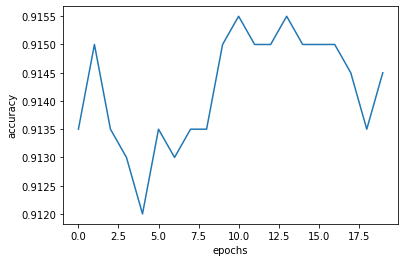

Average Accuracy for Run 1: 0.914199948310852
Highest Accuracy: 0.9154999852180481



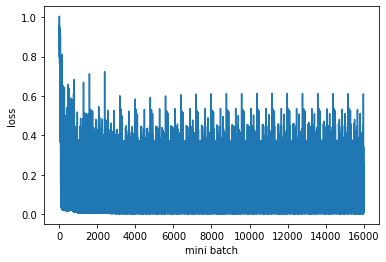

Average Loss for Run 1: 0.11759548634290695
Lowest Loss: 0.0013196691870689392

Run #2



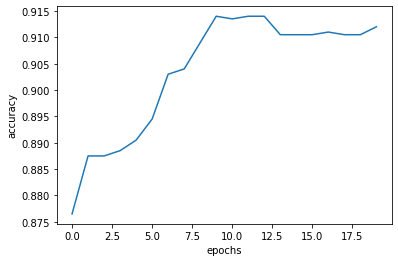

Average Accuracy for Run 2: 0.9036000370979309
Highest Accuracy: 0.9139999747276306



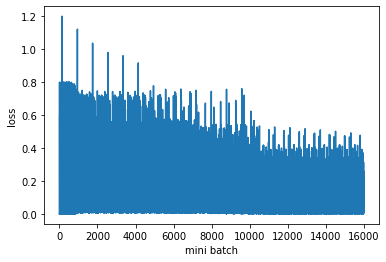

Average Loss for Run 2: 0.1537872552871704
Lowest Loss: 6.027059953339631e-07

Run #3



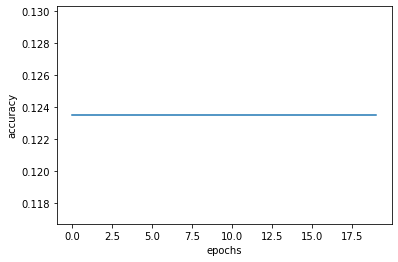

Average Accuracy for Run 3: 0.12350001186132431
Highest Accuracy: 0.12349999696016312



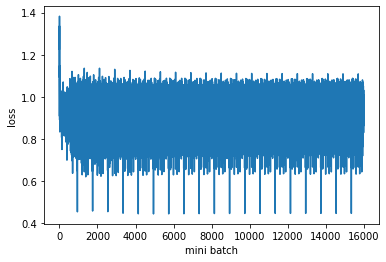

Average Loss for Run 3: 0.9334211349487305
Lowest Loss: 0.44482365250587463

Run #4



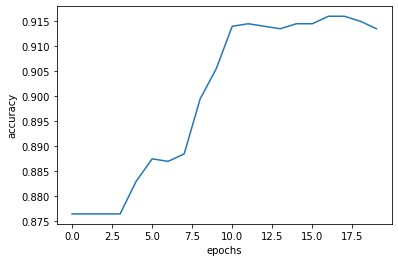

Average Accuracy for Run 4: 0.9001250267028809
Highest Accuracy: 0.9160000085830688



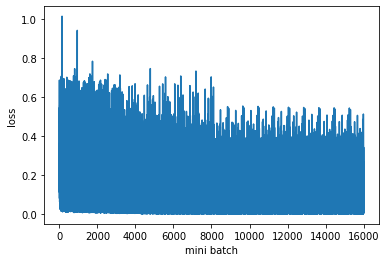

Average Loss for Run 4: 0.14305447041988373
Lowest Loss: 0.0001956502383109182

Run #5



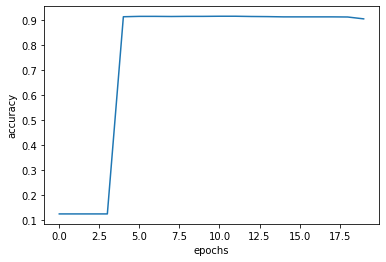

Average Accuracy for Run 5: 0.7555500268936157
Highest Accuracy: 0.9154999852180481



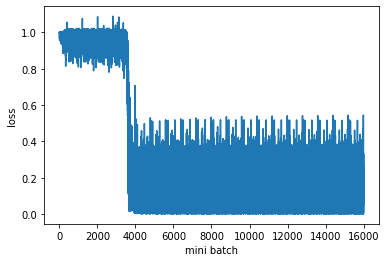

Average Loss for Run 5: 0.3050329387187958
Lowest Loss: 0.0004800990573130548

Run #6



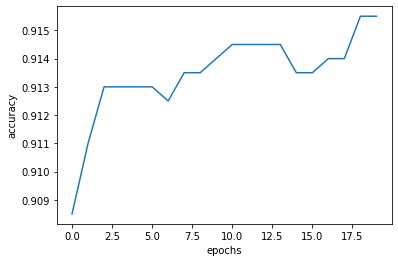

Average Accuracy for Run 6: 0.9134500622749329
Highest Accuracy: 0.9154999852180481



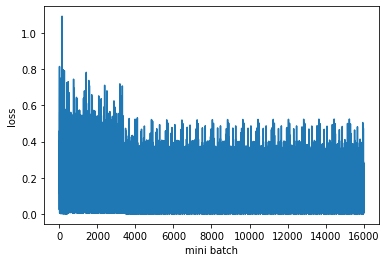

Average Loss for Run 6: 0.11856230348348618
Lowest Loss: 0.0003137111198157072

Run #7



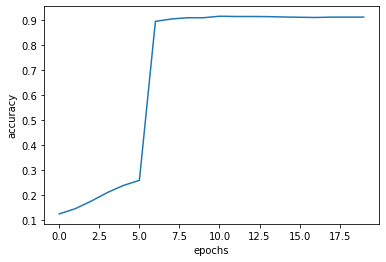

Average Accuracy for Run 7: 0.6947499513626099
Highest Accuracy: 0.9154999852180481



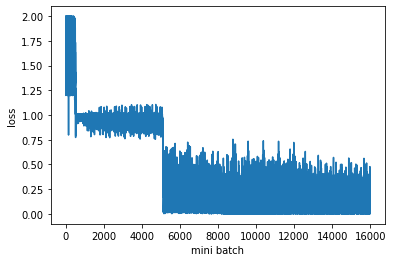

Average Loss for Run 7: 0.42445093393325806
Lowest Loss: 1.9030940165976062e-06

Run #8



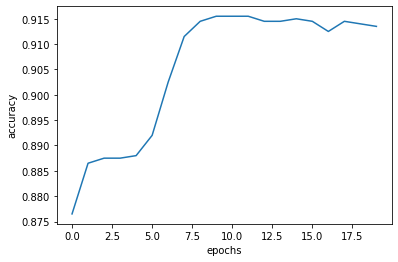

Average Accuracy for Run 8: 0.905299961566925
Highest Accuracy: 0.9154999852180481



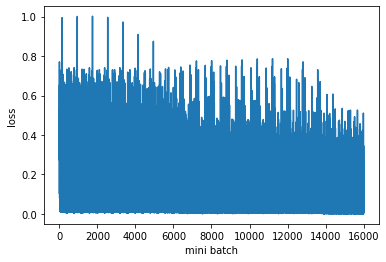

Average Loss for Run 8: 0.16400395333766937
Lowest Loss: 0.00022481728228740394

Run #9



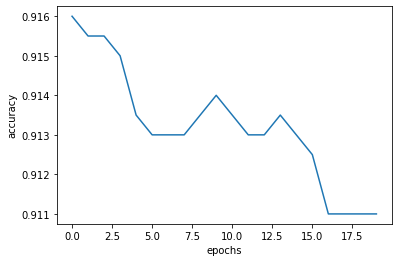

Average Accuracy for Run 9: 0.9132248759269714
Highest Accuracy: 0.9160000085830688



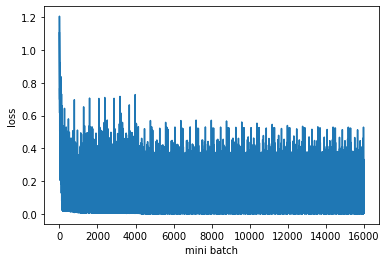

Average Loss for Run 9: 0.11720166355371475
Lowest Loss: 0.000929054687730968

Run #10



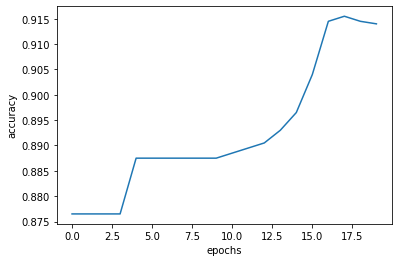

Average Accuracy for Run 10: 0.8925749063491821
Highest Accuracy: 0.9154999852180481



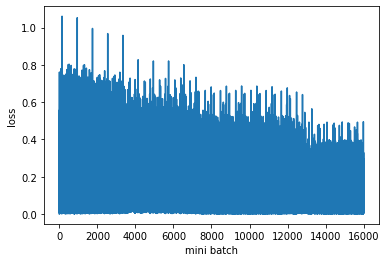

Average Loss for Run 10: 0.17256255447864532
Lowest Loss: 0.00033251807326450944

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.7916275262832642
AVGERAGE LOSS ACCROSS ALL RUNS: 0.26496726274490356


In [ ]:
run_acc_list = []
run_loss_list = []

print("SIGMOID NETWORKS BATCH 10")
for i in range(10):
  key, net = make_network(key, shape = (2, 3, 2), activations = (SIGMOID, SIGMOID), error = (MEAN_SQUARED, MEAN_SQUARED))
  acc_list, avg_list, _ = train(net, smaller_data, smaller_output, learning_rate = 1, epochs = 20, batch_size = 10, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

SIGMOID NETWORKS BATCH 100

Run #1



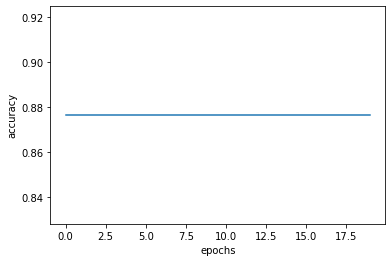

Average Accuracy for Run 1: 0.8764999508857727
Highest Accuracy: 0.8765000104904175



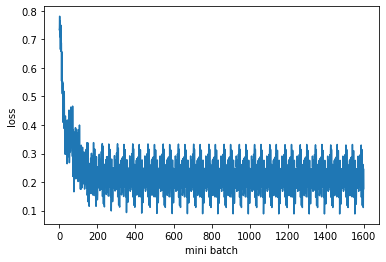

Average Loss for Run 1: 0.23039519786834717
Lowest Loss: 0.08831600844860077

Run #2



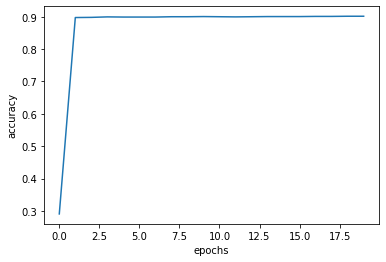

Average Accuracy for Run 2: 0.8694750070571899
Highest Accuracy: 0.9014999866485596



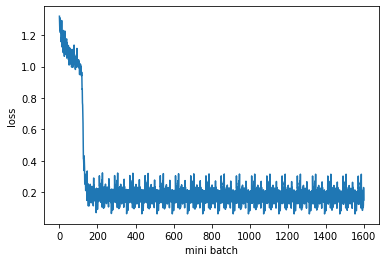

Average Loss for Run 2: 0.2513575255870819
Lowest Loss: 0.06343404948711395

Run #3



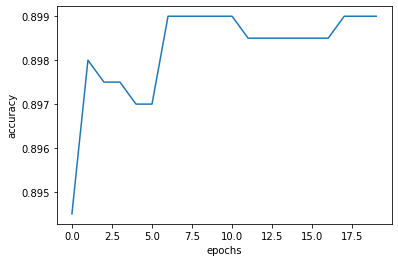

Average Accuracy for Run 3: 0.8982250094413757
Highest Accuracy: 0.8989999890327454



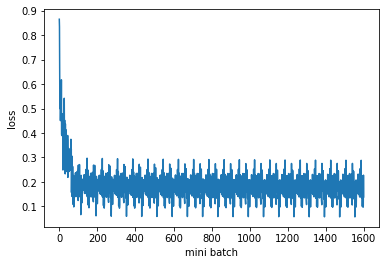

Average Loss for Run 3: 0.18805427849292755
Lowest Loss: 0.05733128637075424

Run #4



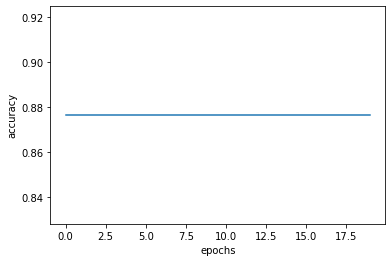

Average Accuracy for Run 4: 0.8764999508857727
Highest Accuracy: 0.8765000104904175



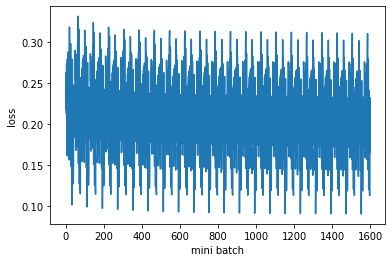

Average Loss for Run 4: 0.2079678773880005
Lowest Loss: 0.09064212441444397

Run #5



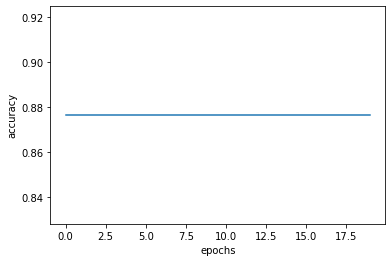

Average Accuracy for Run 5: 0.8764999508857727
Highest Accuracy: 0.8765000104904175



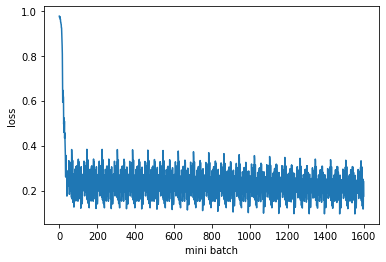

Average Loss for Run 5: 0.23909908533096313
Lowest Loss: 0.09626370668411255

Run #6



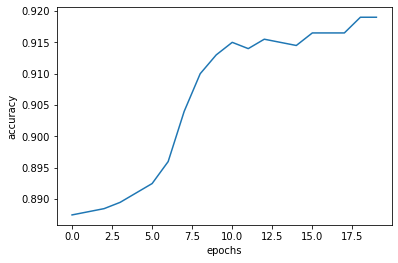

Average Accuracy for Run 6: 0.906075119972229
Highest Accuracy: 0.9190000295639038



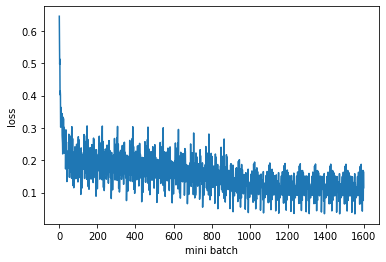

Average Loss for Run 6: 0.1540040522813797
Lowest Loss: 0.033966436982154846

Run #7



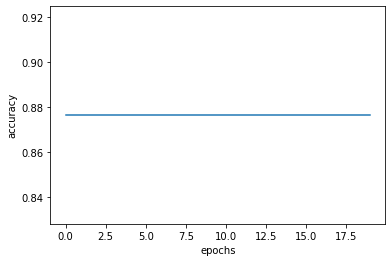

Average Accuracy for Run 7: 0.8764999508857727
Highest Accuracy: 0.8765000104904175



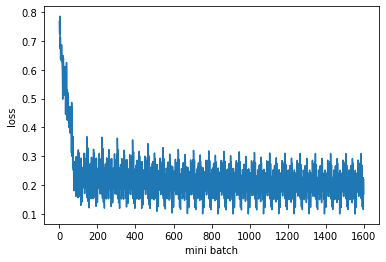

Average Loss for Run 7: 0.22616569697856903
Lowest Loss: 0.09944101423025131

Run #8



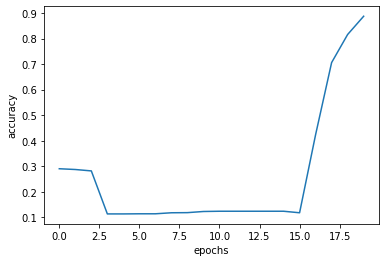

Average Accuracy for Run 8: 0.2618749737739563
Highest Accuracy: 0.887499988079071



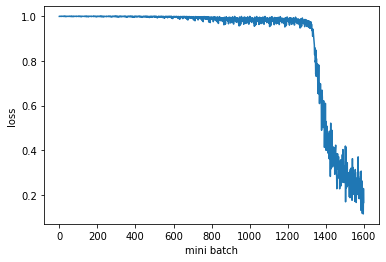

Average Loss for Run 8: 0.8920506238937378
Lowest Loss: 0.11556672304868698

Run #9



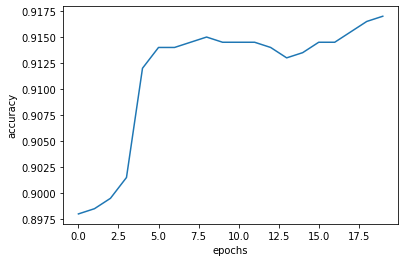

Average Accuracy for Run 9: 0.9114500284194946
Highest Accuracy: 0.9169999957084656



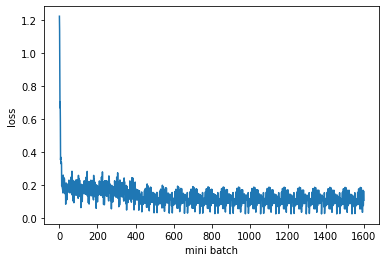

Average Loss for Run 9: 0.13335385918617249
Lowest Loss: 0.02725866064429283

Run #10



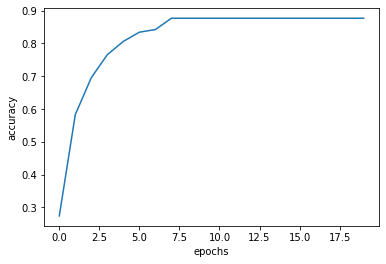

Average Accuracy for Run 10: 0.8097249865531921
Highest Accuracy: 0.8765000104904175



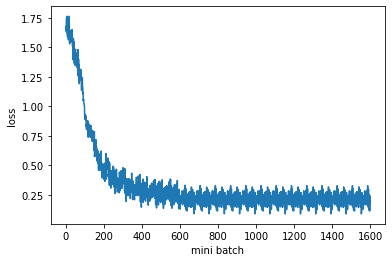

Average Loss for Run 10: 0.3415140211582184
Lowest Loss: 0.0884307399392128

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.8162824511528015
AVGERAGE LOSS ACCROSS ALL RUNS: 0.28639620542526245


In [ ]:
run_acc_list = []
run_loss_list = []

print("SIGMOID NETWORKS BATCH 100")
for i in range(10):
  key, net = make_network(key, shape = (2, 3, 2), activations = (SIGMOID, SIGMOID), error = (MEAN_SQUARED, MEAN_SQUARED))
  acc_list, avg_list, _ = train(net, smaller_data, smaller_output, learning_rate = 1, epochs = 20, batch_size = 100, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

TANH NETWORKS BATCH 100

Run #1



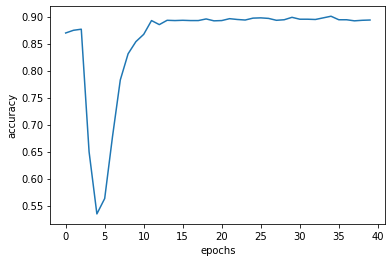

Average Accuracy for Run 1: 0.8577375411987305
Highest Accuracy: 0.9004999995231628



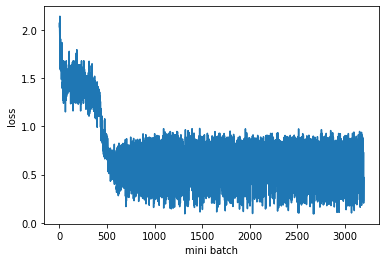

Average Loss for Run 1: 0.7042986154556274
Lowest Loss: 0.09127812087535858

Run #2



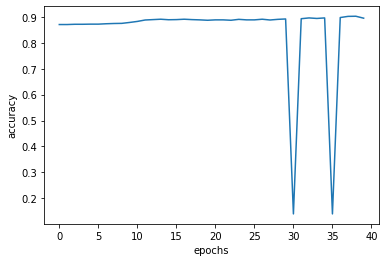

Average Accuracy for Run 2: 0.8490749597549438
Highest Accuracy: 0.9024999737739563



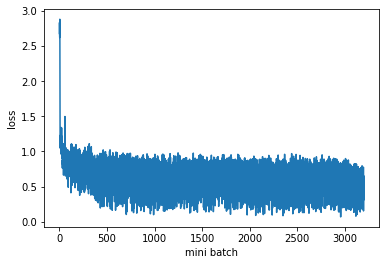

Average Loss for Run 2: 0.6056948304176331
Lowest Loss: 0.06804253906011581

Run #3



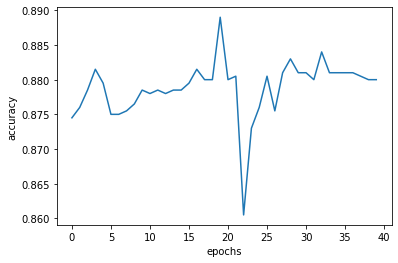

Average Accuracy for Run 3: 0.8788124918937683
Highest Accuracy: 0.8889999985694885



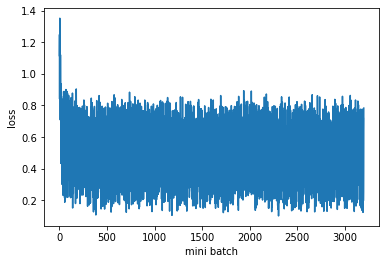

Average Loss for Run 3: 0.4895711839199066
Lowest Loss: 0.09979512542486191

Run #4



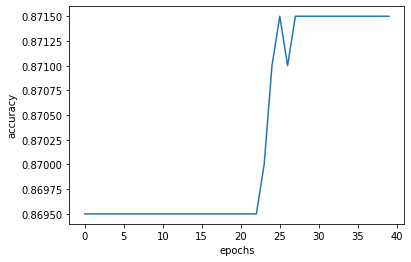

Average Accuracy for Run 4: 0.8702875375747681
Highest Accuracy: 0.8715000152587891



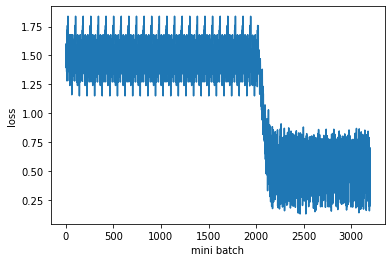

Average Loss for Run 4: 1.1350326538085938
Lowest Loss: 0.12642931938171387

Run #5



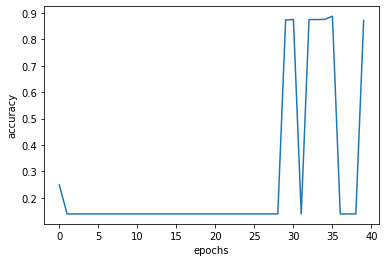

Average Accuracy for Run 5: 0.2710624933242798
Highest Accuracy: 0.8870000243186951



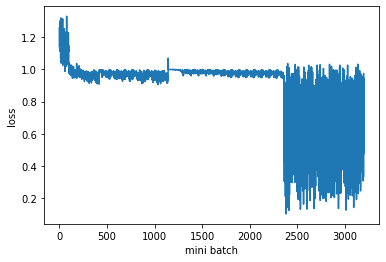

Average Loss for Run 5: 0.897291898727417
Lowest Loss: 0.10378619283437729

Run #6



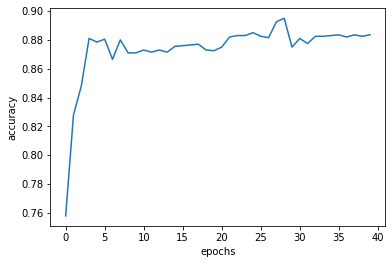

Average Accuracy for Run 6: 0.8739500045776367
Highest Accuracy: 0.8949999809265137



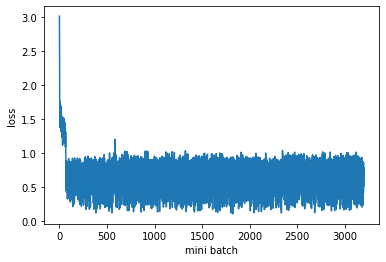

Average Loss for Run 6: 0.6430273652076721
Lowest Loss: 0.09988564252853394

Run #7



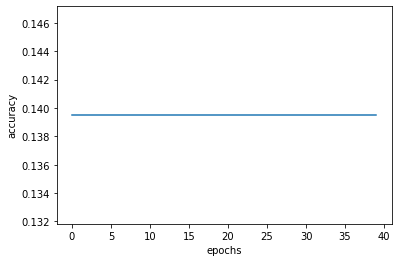

Average Accuracy for Run 7: 0.1394999921321869
Highest Accuracy: 0.13950000703334808



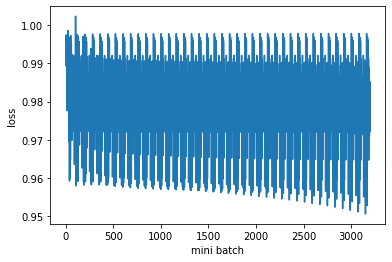

Average Loss for Run 7: 0.979481041431427
Lowest Loss: 0.9505589008331299

Run #8



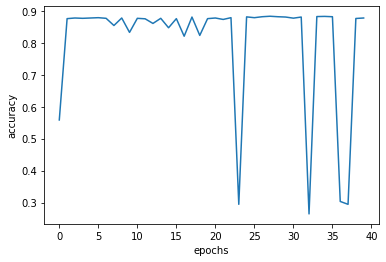

Average Accuracy for Run 8: 0.8055999875068665
Highest Accuracy: 0.8830000162124634



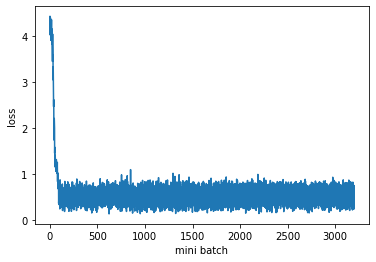

Average Loss for Run 8: 0.569379448890686
Lowest Loss: 0.1393996924161911

Run #9



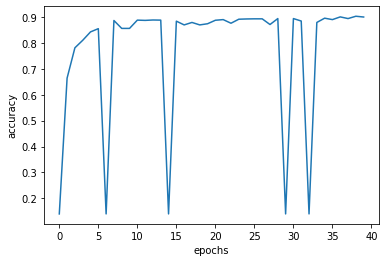

Average Accuracy for Run 9: 0.7805625200271606
Highest Accuracy: 0.9035000205039978



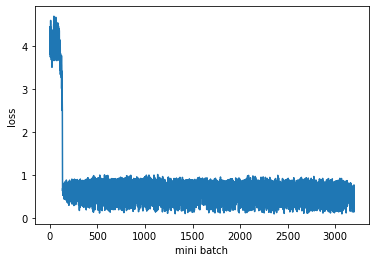

Average Loss for Run 9: 0.7323002815246582
Lowest Loss: 0.0971909835934639

Run #10



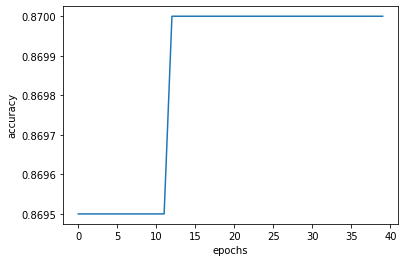

Average Accuracy for Run 10: 0.8698500394821167
Highest Accuracy: 0.8700000047683716



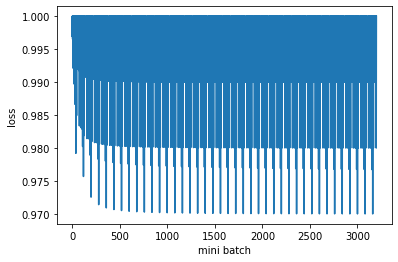

Average Loss for Run 10: 0.9942021369934082
Lowest Loss: 0.9700531959533691

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.719643771648407
AVGERAGE LOSS ACCROSS ALL RUNS: 0.7750279307365417


In [ ]:
run_acc_list = []
run_loss_list = []

print("TANH NETWORKS BATCH 100")
for i in range(10):
  key, net = make_network(key, shape = (2, 3, 2), activations = (TANH, TANH), error = (MEAN_SQUARED, MEAN_SQUARED))
  acc_list, avg_list, _ = train(net, smaller_data, smaller_output, learning_rate = .7, epochs = 40, batch_size = 100, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

RELU-SIGMOID NETWORKS BATCH 100

Run #1



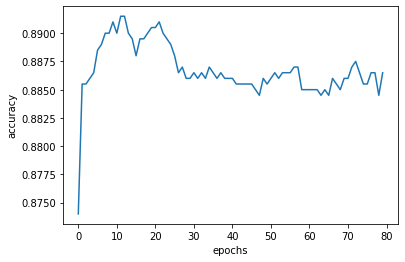

Average Accuracy for Run 1: 0.8867812156677246
Highest Accuracy: 0.8914999961853027



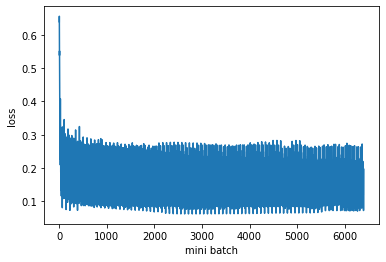

Average Loss for Run 1: 0.17854279279708862
Lowest Loss: 0.06144265830516815

Run #2



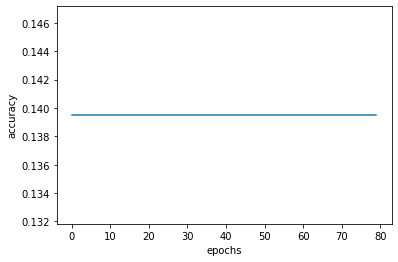

Average Accuracy for Run 2: 0.1394999921321869
Highest Accuracy: 0.13950000703334808



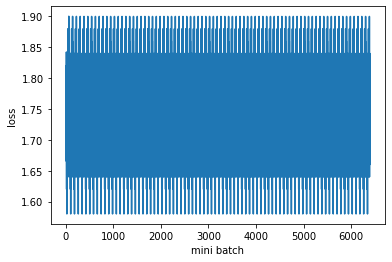

Average Loss for Run 2: 1.7517682313919067
Lowest Loss: 1.5800000429153442

Run #3



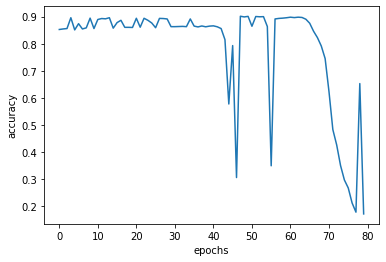

Average Accuracy for Run 3: 0.7905062437057495
Highest Accuracy: 0.9014999866485596



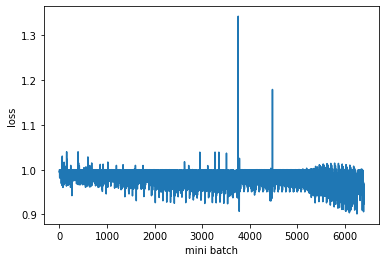

Average Loss for Run 3: 0.9800328016281128
Lowest Loss: 0.901255190372467

Run #4



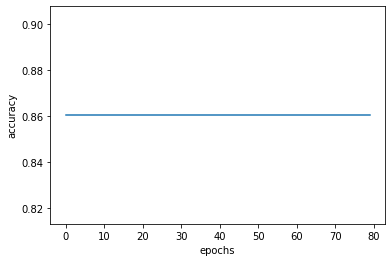

Average Accuracy for Run 4: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



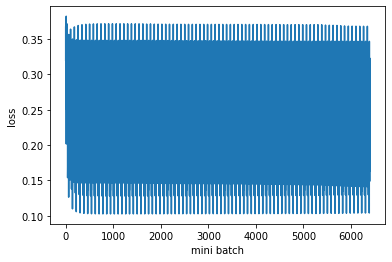

Average Loss for Run 4: 0.2304127812385559
Lowest Loss: 0.10278249531984329

Run #5



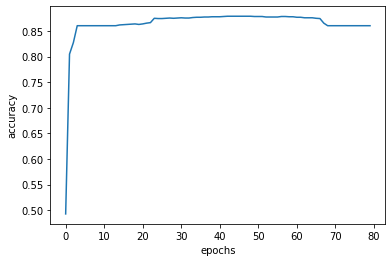

Average Accuracy for Run 5: 0.8643625378608704
Highest Accuracy: 0.8790000081062317



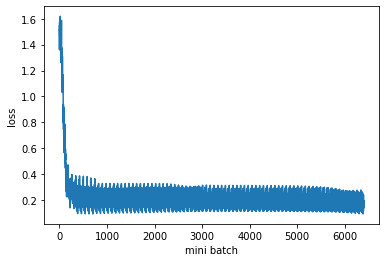

Average Loss for Run 5: 0.22044311463832855
Lowest Loss: 0.09270527958869934

Run #6



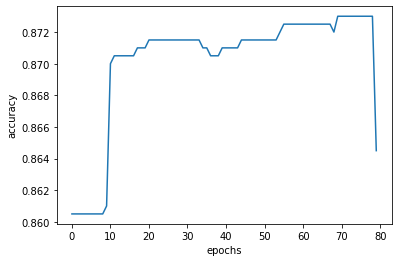

Average Accuracy for Run 6: 0.8702125549316406
Highest Accuracy: 0.8730000257492065



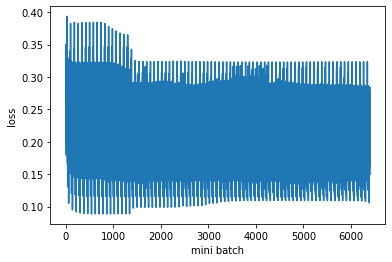

Average Loss for Run 6: 0.21162723004817963
Lowest Loss: 0.08866143226623535

Run #7



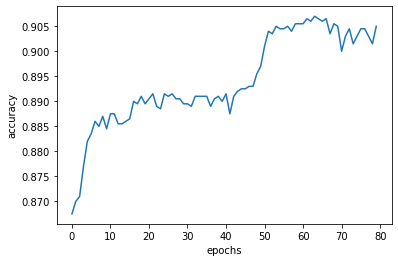

Average Accuracy for Run 7: 0.8941937685012817
Highest Accuracy: 0.9070000052452087



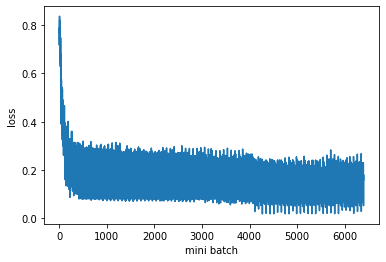

Average Loss for Run 7: 0.1789158582687378
Lowest Loss: 0.0180496945977211

Run #8



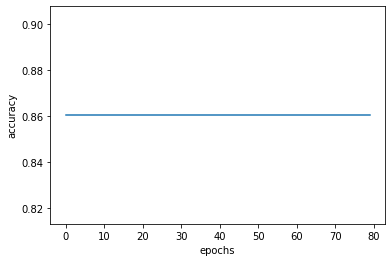

Average Accuracy for Run 8: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



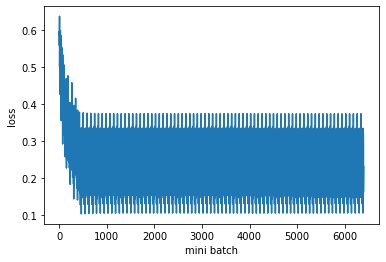

Average Loss for Run 8: 0.23842033743858337
Lowest Loss: 0.10219859331846237

Run #9



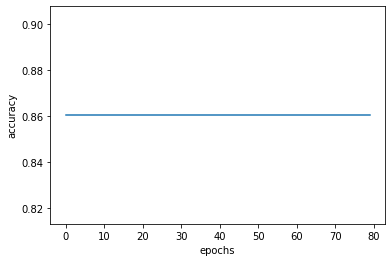

Average Accuracy for Run 9: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



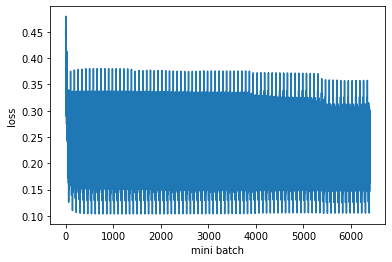

Average Loss for Run 9: 0.22959856688976288
Lowest Loss: 0.10384201258420944

Run #10



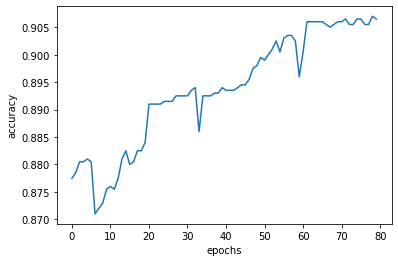

Average Accuracy for Run 10: 0.8936311602592468
Highest Accuracy: 0.9070000052452087



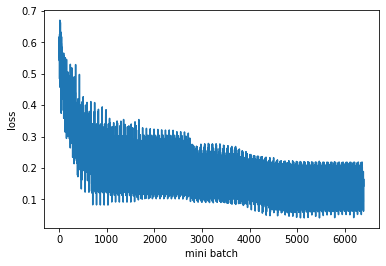

Average Loss for Run 10: 0.1893812119960785
Lowest Loss: 0.04061179980635643

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.7920687794685364
AVGERAGE LOSS ACCROSS ALL RUNS: 0.4409143030643463


In [ ]:
run_acc_list = []
run_loss_list = []

print("RELU-SIGMOID NETWORKS BATCH 100")
for i in range(10):
  key, net = make_network(key, shape = (2, 3, 2), activations = (RELU, SIGMOID), error = (MEAN_SQUARED, MEAN_SQUARED))
  acc_list, avg_list, _ = train(net, smaller_data, smaller_output, learning_rate = .5, epochs = 80, batch_size = 100, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

In [ ]:
key, net = make_network(key, shape = (2, 3, 2), activations = (RELU, SIGMOID), error = (MEAN_SQUARED, MEAN_SQUARED))

RELU-SIGMOID SINGLE NETWORK BATCH 100

Run #1



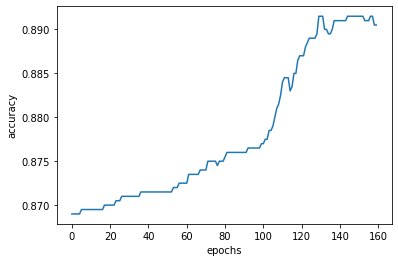

Average Accuracy for Run 1: 0.8781719207763672
Highest Accuracy: 0.8914999961853027



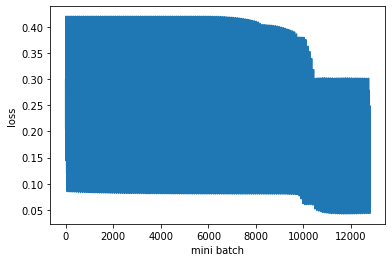

Average Loss for Run 1: 0.22022342681884766
Lowest Loss: 0.042229682207107544

Run #2



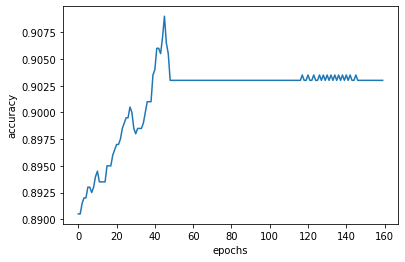

Average Accuracy for Run 2: 0.9015375375747681
Highest Accuracy: 0.9089999794960022



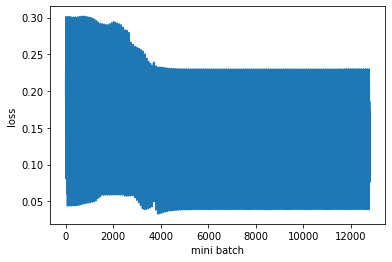

Average Loss for Run 2: 0.14379549026489258
Lowest Loss: 0.03285273537039757

Run #3



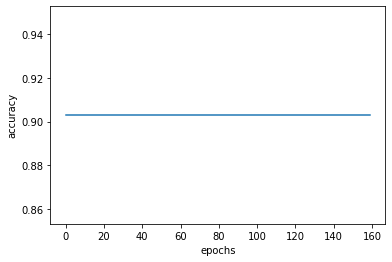

Average Accuracy for Run 3: 0.9030000567436218
Highest Accuracy: 0.902999997138977



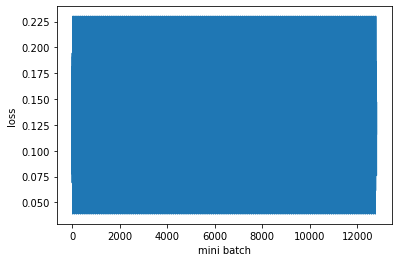

Average Loss for Run 3: 0.13241875171661377
Lowest Loss: 0.03881348296999931

Run #4



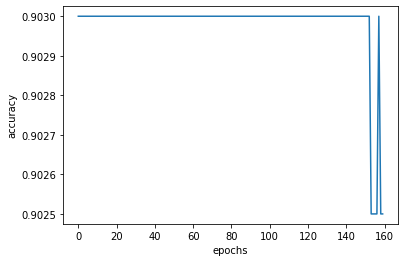

Average Accuracy for Run 4: 0.902981162071228
Highest Accuracy: 0.902999997138977



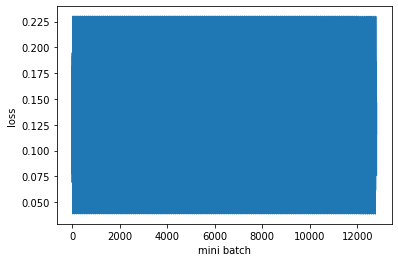

Average Loss for Run 4: 0.13234660029411316
Lowest Loss: 0.03860919550061226

Run #5



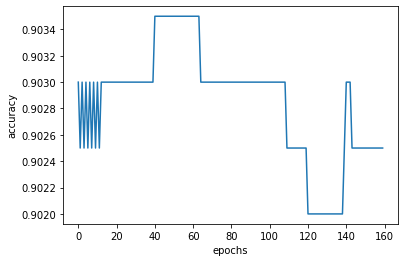

Average Accuracy for Run 5: 0.9028468132019043
Highest Accuracy: 0.9035000205039978



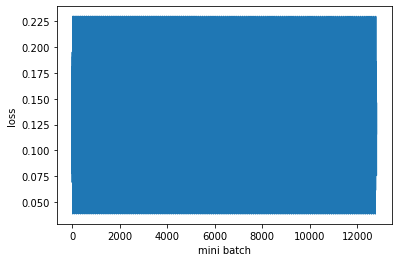

Average Loss for Run 5: 0.13222120702266693
Lowest Loss: 0.03847511485219002

Run #6



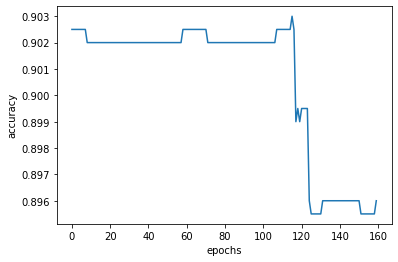

Average Accuracy for Run 6: 0.9005905985832214
Highest Accuracy: 0.902999997138977



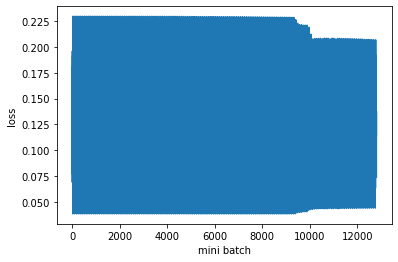

Average Loss for Run 6: 0.1312950700521469
Lowest Loss: 0.03838862478733063

Run #7



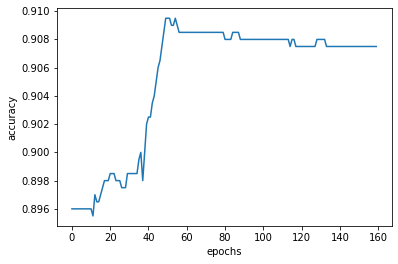

Average Accuracy for Run 7: 0.9052499532699585
Highest Accuracy: 0.909500002861023



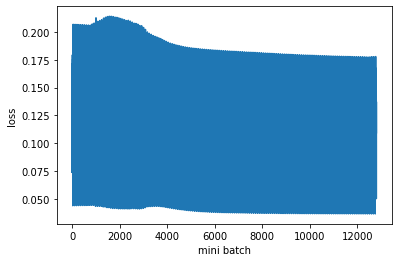

Average Loss for Run 7: 0.12014804780483246
Lowest Loss: 0.03672510012984276

Run #8



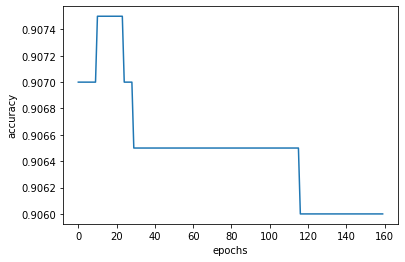

Average Accuracy for Run 8: 0.9064968228340149
Highest Accuracy: 0.9075000286102295



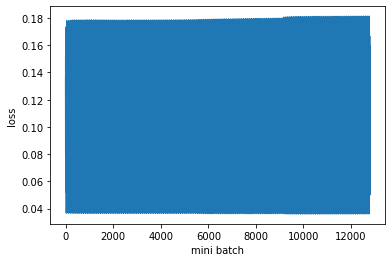

Average Loss for Run 8: 0.11622872948646545
Lowest Loss: 0.036092400550842285

Run #9



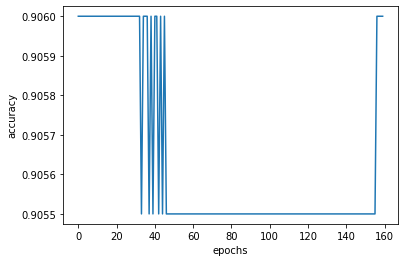

Average Accuracy for Run 9: 0.9056406021118164
Highest Accuracy: 0.906000018119812



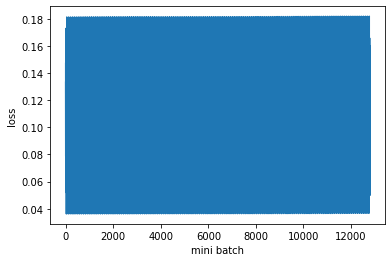

Average Loss for Run 9: 0.11596553772687912
Lowest Loss: 0.036167193204164505

Run #10



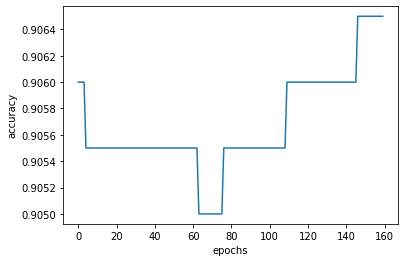

Average Accuracy for Run 10: 0.905674934387207
Highest Accuracy: 0.906499981880188



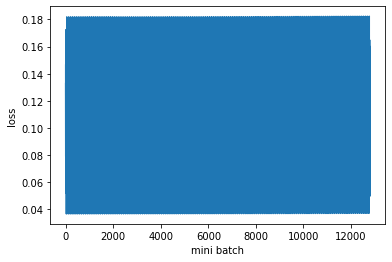

Average Loss for Run 10: 0.11587108671665192
Lowest Loss: 0.036643579602241516

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.9012190103530884
AVGERAGE LOSS ACCROSS ALL RUNS: 0.13605138659477234


In [ ]:
run_acc_list = []
run_loss_list = []

net_1 = [Layer(net[0].weights, net[0].biases, RELU, MEAN_SQUARED), Layer(net[1].weights, net[1].biases, SIGMOID, MEAN_SQUARED)]

print("RELU-SIGMOID SINGLE NETWORK BATCH 100")
for i in range(10):
  acc_list, avg_list, net_1 = train(net_1, smaller_data, smaller_output, learning_rate = .3, epochs = 160, batch_size = 100, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

RELU-TANH SINGLE NETWORK BATCH 100

Run #1



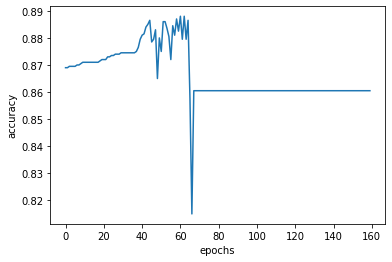

Average Accuracy for Run 1: 0.8664843440055847
Highest Accuracy: 0.8880000114440918



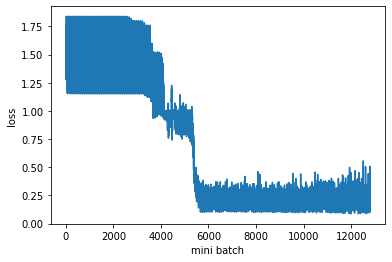

Average Loss for Run 1: 0.6752669811248779
Lowest Loss: 0.08545242995023727

Run #2



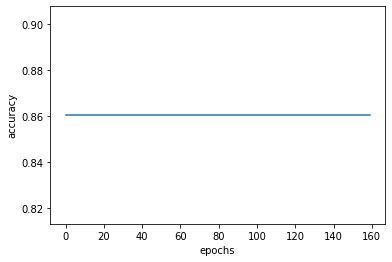

Average Accuracy for Run 2: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



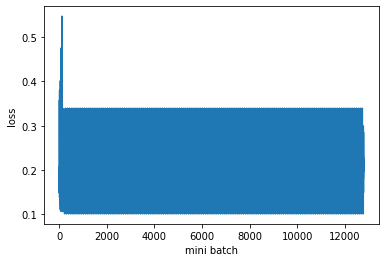

Average Loss for Run 2: 0.21663245558738708
Lowest Loss: 0.10099300742149353

Run #3



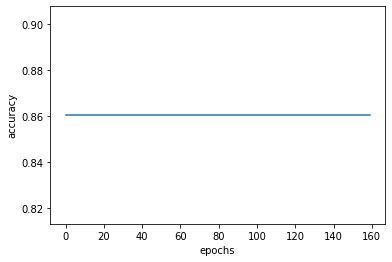

Average Accuracy for Run 3: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



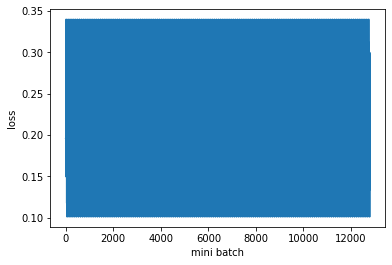

Average Loss for Run 3: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #4



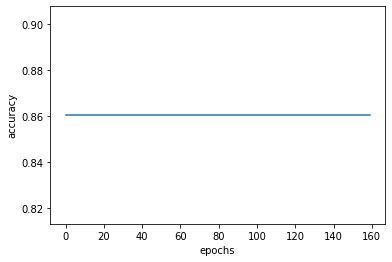

Average Accuracy for Run 4: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



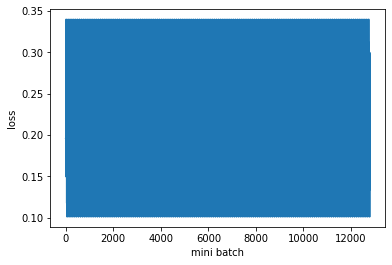

Average Loss for Run 4: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #5



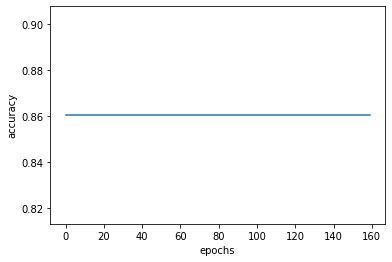

Average Accuracy for Run 5: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



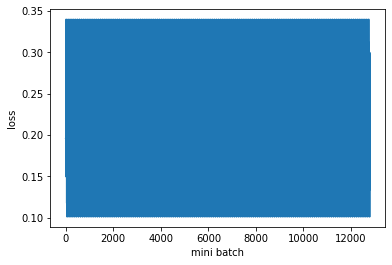

Average Loss for Run 5: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #6



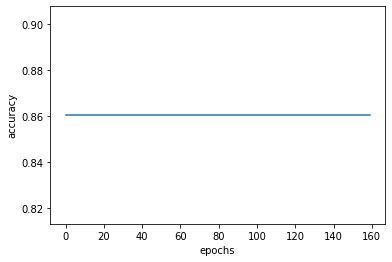

Average Accuracy for Run 6: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



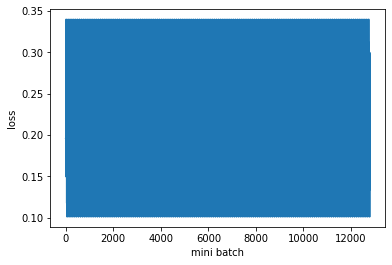

Average Loss for Run 6: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #7



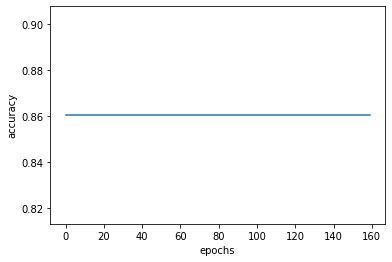

Average Accuracy for Run 7: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



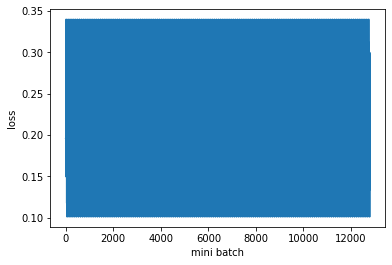

Average Loss for Run 7: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #8



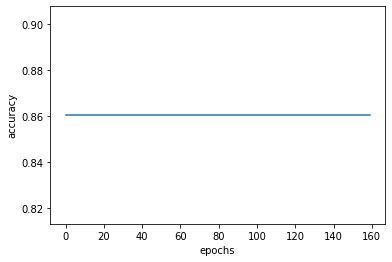

Average Accuracy for Run 8: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



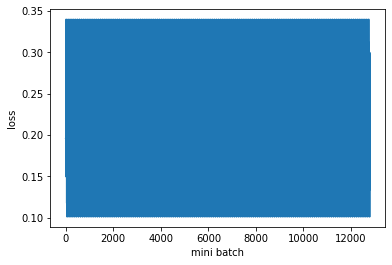

Average Loss for Run 8: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #9



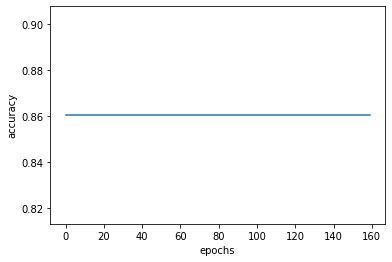

Average Accuracy for Run 9: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



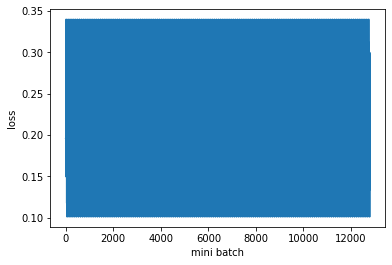

Average Loss for Run 9: 0.2166418582201004
Lowest Loss: 0.10099300742149353

Run #10



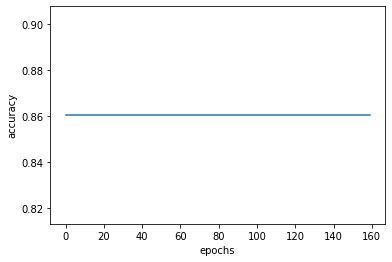

Average Accuracy for Run 10: 0.8604999780654907
Highest Accuracy: 0.8604999780654907



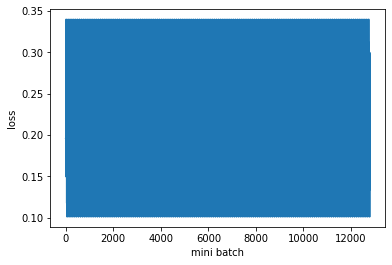

Average Loss for Run 10: 0.2166418582201004
Lowest Loss: 0.10099300742149353

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.8610984086990356
AVGERAGE LOSS ACCROSS ALL RUNS: 0.262503445148468


In [ ]:
run_acc_list = []
run_loss_list = []

net_2 = [Layer(net[0].weights, net[0].biases, RELU, MEAN_SQUARED), Layer(net[1].weights, net[1].biases, TANH, MEAN_SQUARED)]

print("RELU-TANH SINGLE NETWORK BATCH 100")
for i in range(10):
  acc_list, avg_list, net_2 = train(net_2, smaller_data, smaller_output, learning_rate = .3, epochs = 160, batch_size = 100, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

TANH-SIGMOID SINGLE NETWORK BATCH 100

Run #1



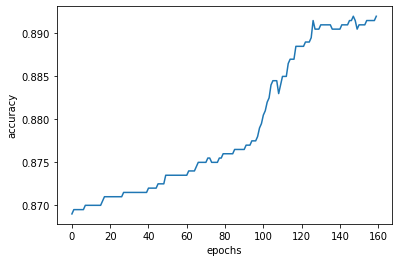

Average Accuracy for Run 1: 0.8790531158447266
Highest Accuracy: 0.8920000195503235



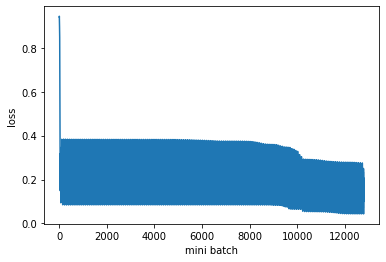

Average Loss for Run 1: 0.207851842045784
Lowest Loss: 0.04345887154340744

Run #2



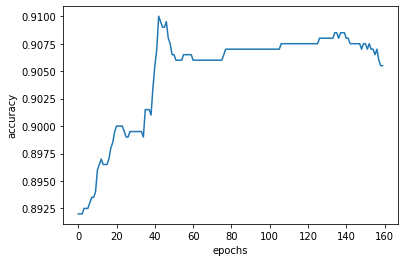

Average Accuracy for Run 2: 0.9047375917434692
Highest Accuracy: 0.9100000262260437



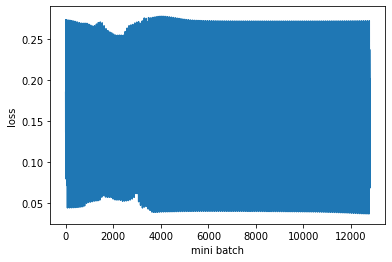

Average Loss for Run 2: 0.1621425300836563
Lowest Loss: 0.03624337539076805

Run #3



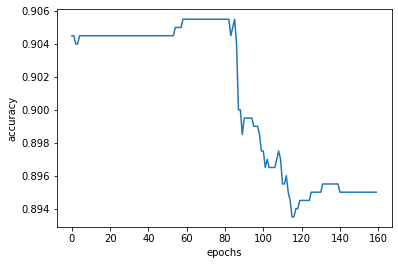

Average Accuracy for Run 3: 0.9007749557495117
Highest Accuracy: 0.9054999947547913



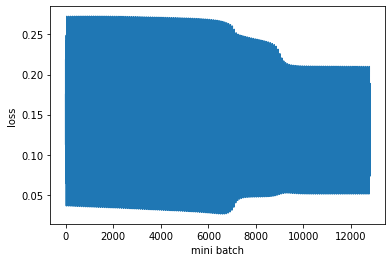

Average Loss for Run 3: 0.14430254697799683
Lowest Loss: 0.02606765739619732

Run #4



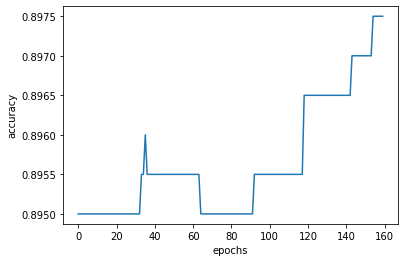

Average Accuracy for Run 4: 0.895646870136261
Highest Accuracy: 0.8974999785423279



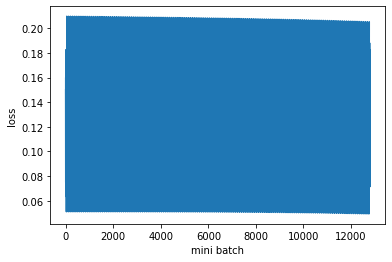

Average Loss for Run 4: 0.1278982013463974
Lowest Loss: 0.049246110022068024

Run #5



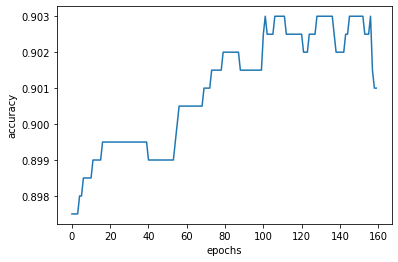

Average Accuracy for Run 5: 0.9009812474250793
Highest Accuracy: 0.902999997138977



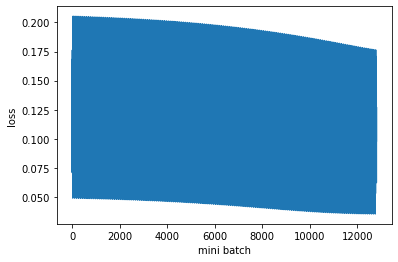

Average Loss for Run 5: 0.12261611968278885
Lowest Loss: 0.03558264300227165

Run #6



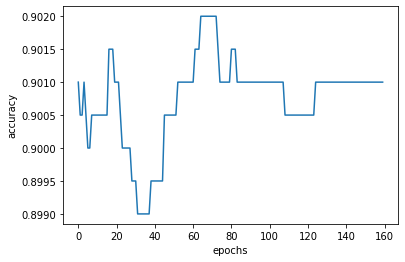

Average Accuracy for Run 6: 0.9007499814033508
Highest Accuracy: 0.9020000100135803



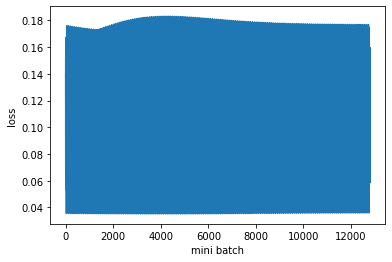

Average Loss for Run 6: 0.11499257385730743
Lowest Loss: 0.03517039492726326

Run #7



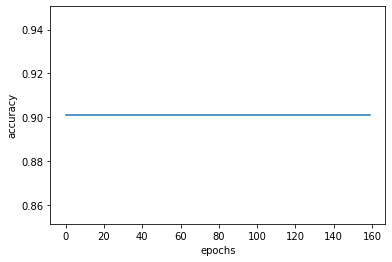

Average Accuracy for Run 7: 0.9010000228881836
Highest Accuracy: 0.9010000228881836



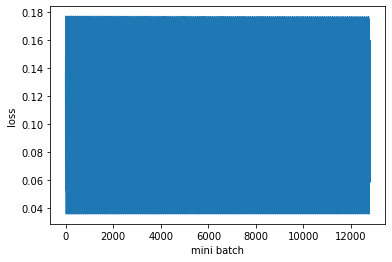

Average Loss for Run 7: 0.11482787877321243
Lowest Loss: 0.03588930889964104

Run #8



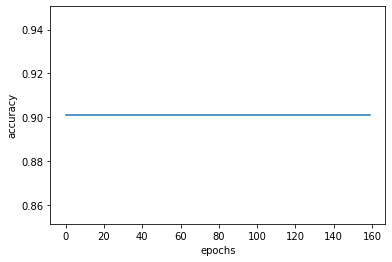

Average Accuracy for Run 8: 0.9010000228881836
Highest Accuracy: 0.9010000228881836



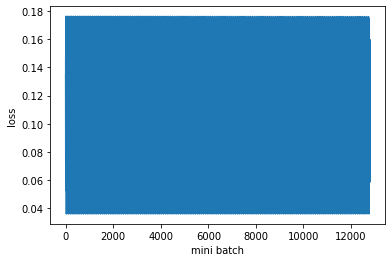

Average Loss for Run 8: 0.1148257702589035
Lowest Loss: 0.035945095121860504

Run #9



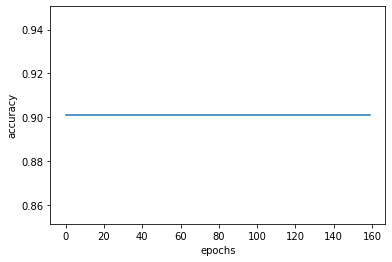

Average Accuracy for Run 9: 0.9010000228881836
Highest Accuracy: 0.9010000228881836



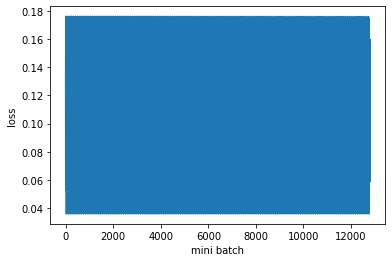

Average Loss for Run 9: 0.11482418328523636
Lowest Loss: 0.0359715111553669

Run #10



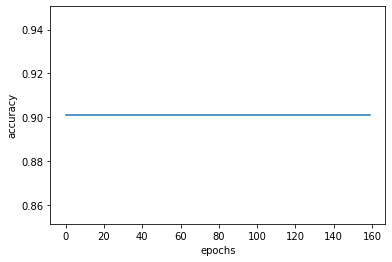

Average Accuracy for Run 10: 0.9010000228881836
Highest Accuracy: 0.9010000228881836



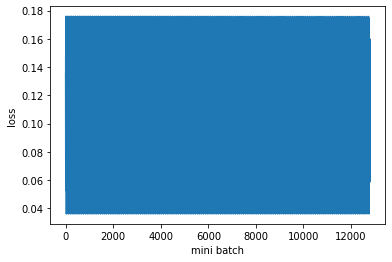

Average Loss for Run 10: 0.11482303589582443
Lowest Loss: 0.03599287196993828

AVGERAGE ACCURACY ACCROSS ALL RUNS: 0.8985943794250488
AVGERAGE LOSS ACCROSS ALL RUNS: 0.13391046226024628


In [ ]:
run_acc_list = []
run_loss_list = []

net_3 = [Layer(net[0].weights, net[0].biases, TANH, MEAN_SQUARED), Layer(net[1].weights, net[1].biases, SIGMOID, MEAN_SQUARED)]

print("TANH-SIGMOID SINGLE NETWORK BATCH 100")
for i in range(10):
  acc_list, avg_list, net_3 = train(net_3, smaller_data, smaller_output, learning_rate = .3, epochs = 160, batch_size = 100, train_percent = .8)

  print()

  print(f"Run #{i + 1}\n")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.plot(acc_list)
  plt.show()
  run_avg = jnp.sum(jnp.array(acc_list)) / len(acc_list)
  run_acc_list.append(run_avg)
  print(f"Average Accuracy for Run {i + 1}: {run_avg}")
  print(f"Highest Accuracy: {jnp.max(jnp.array(acc_list))}")

  print()

  plt.xlabel("mini batch")
  plt.ylabel("loss")
  plt.plot(avg_list)  
  plt.show()
  run_avg = jnp.sum(jnp.array(avg_list)) / len(avg_list)
  run_loss_list.append(run_avg)
  print(f"Average Loss for Run {i + 1}: {run_avg}")
  print(f"Lowest Loss: {jnp.min(jnp.array(avg_list))}")

print()
print(f"AVGERAGE ACCURACY ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_acc_list)) / len(run_acc_list)}")
print(f"AVGERAGE LOSS ACCROSS ALL RUNS: {jnp.sum(jnp.array(run_loss_list)) / len(run_loss_list)}")

In [ ]:
if classify(net, jnp.array([1, 3])):
  print("poisonous")
else:
  print("good")

calc_network_output(net, jnp.array([1, 3]))

poisonous


DeviceArray([0.44996333, 0.54866034], dtype=float32)